# Effect of percipitation on Accident

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline

In [3]:
records=pd.read_csv('random_sample_data_MQ.csv',iterator=True,chunksize=10**5,low_memory=False)
mylist=[]
for chunk in records:
    mylist.append(chunk[['Type','Severity','StartTime(UTC)','LocalTimeZone','City','Precipitation(in)','WeatherSeverity']])
records=pd.concat(mylist)
records['StartTime(UTC)']=pd.to_datetime(records['StartTime(UTC)'])

# transfer time
records=records[records['LocalTimeZone'].notnull()]
dic={'EDT':datetime.timedelta(hours=-4), 'EST':datetime.timedelta(hours=-5),
     'CDT':datetime.timedelta(hours=-5), 'CST':datetime.timedelta(hours=-6), 
     'MDT':datetime.timedelta(hours=-6), 'MST':datetime.timedelta(hours=-7),
     'PDT':datetime.timedelta(hours=-7), 'PST':datetime.timedelta(hours=-8)}
records['StartTime(UTC)']=records['StartTime(UTC)']+records['LocalTimeZone'].map(lambda x:dic[x])
start=datetime.datetime(2016,2,1)
records=records[(records['StartTime(UTC)']>=start)]

## average precipitation based on severity

This part of work is aim to find the relation with precipitation's amount with severity of events. Thus we should remove those days without precipitation.

In [5]:
data=records[records['Precipitation(in)']>0]

### overall

In [6]:
def distribution(df,ax,title):
    value=df.groupby('Severity')['Precipitation(in)'].mean()
    ax.bar(range(5),[value[i] if i in value else 0 for i in range(5)],tick_label=range(5))
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_xlabel('Severity')
    ax.set_ylabel('Average Precipitation/in')

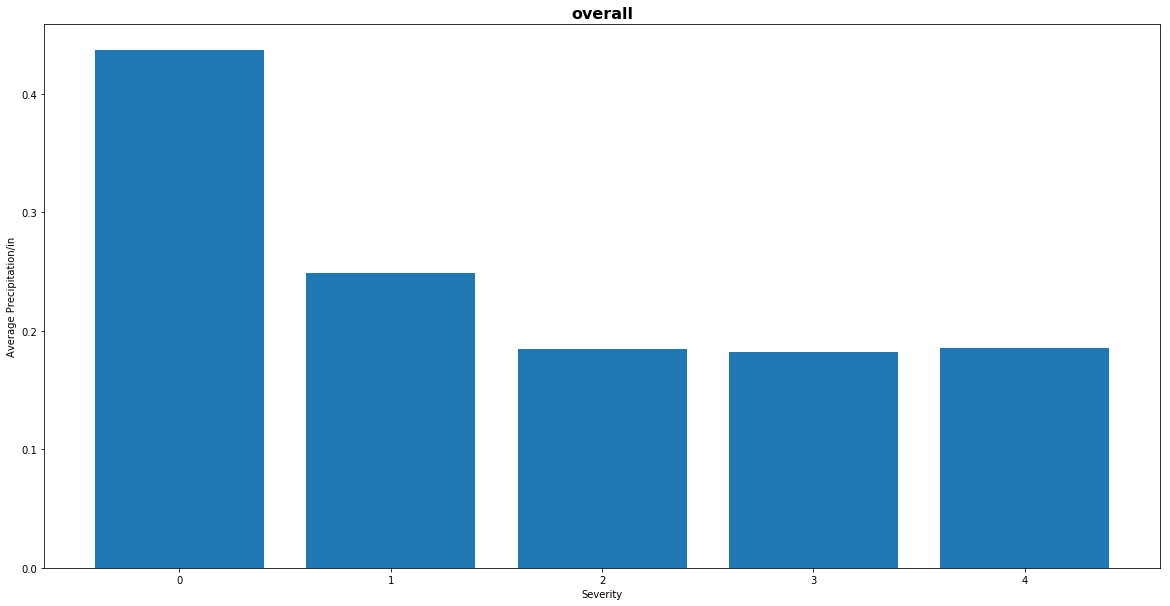

In [7]:
fg, ax = plt.subplots(1, 1, figsize=(20, 10))
distribution(data,ax,'overall')

### different types

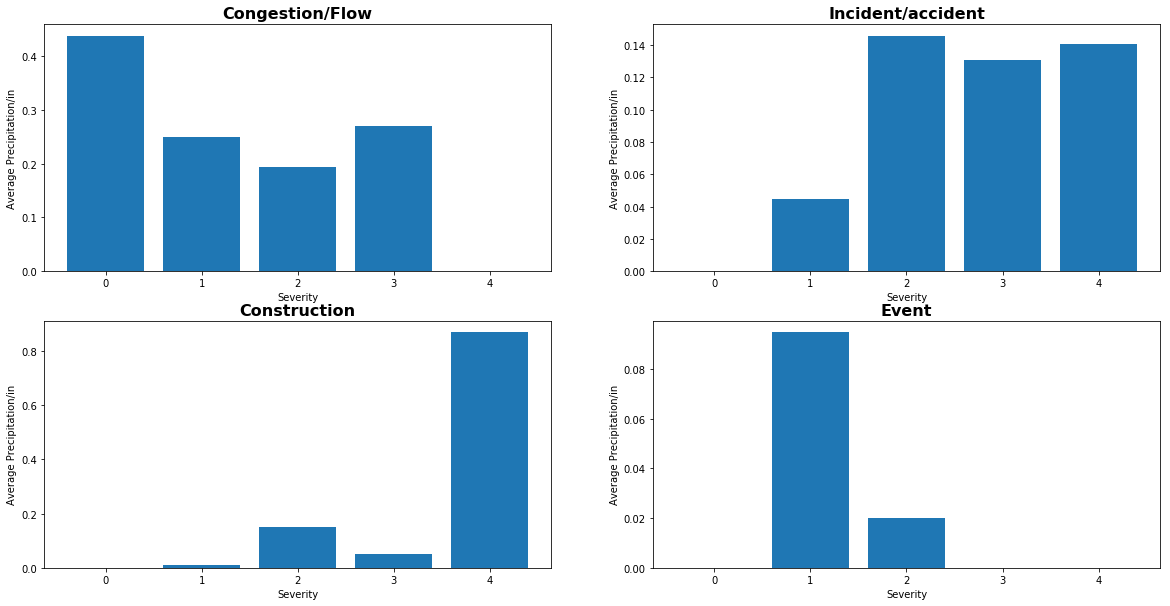

In [8]:
fg,axes=plt.subplots(2, 2, figsize=(20, 10))
kinds=data.Type.unique()
k=0
for i in range(2):
    for j in range(2):
        distribution(data[data['Type']==kinds[k]],axes[i][j],kinds[k])
        k+=1

Clearly, incident and construction's percipitation have a increasing trend with severity.  
Congestion havea decreasing trend with severity.

### Major cities and other cities

In [9]:
cities=data['City'].value_counts()[:10].index
cities

Index(['New York', 'Brooklyn', 'Miami', 'Seattle', 'Houston', 'Chicago',
       'Atlanta', 'Los Angeles', 'Portland', 'Columbus'],
      dtype='object')

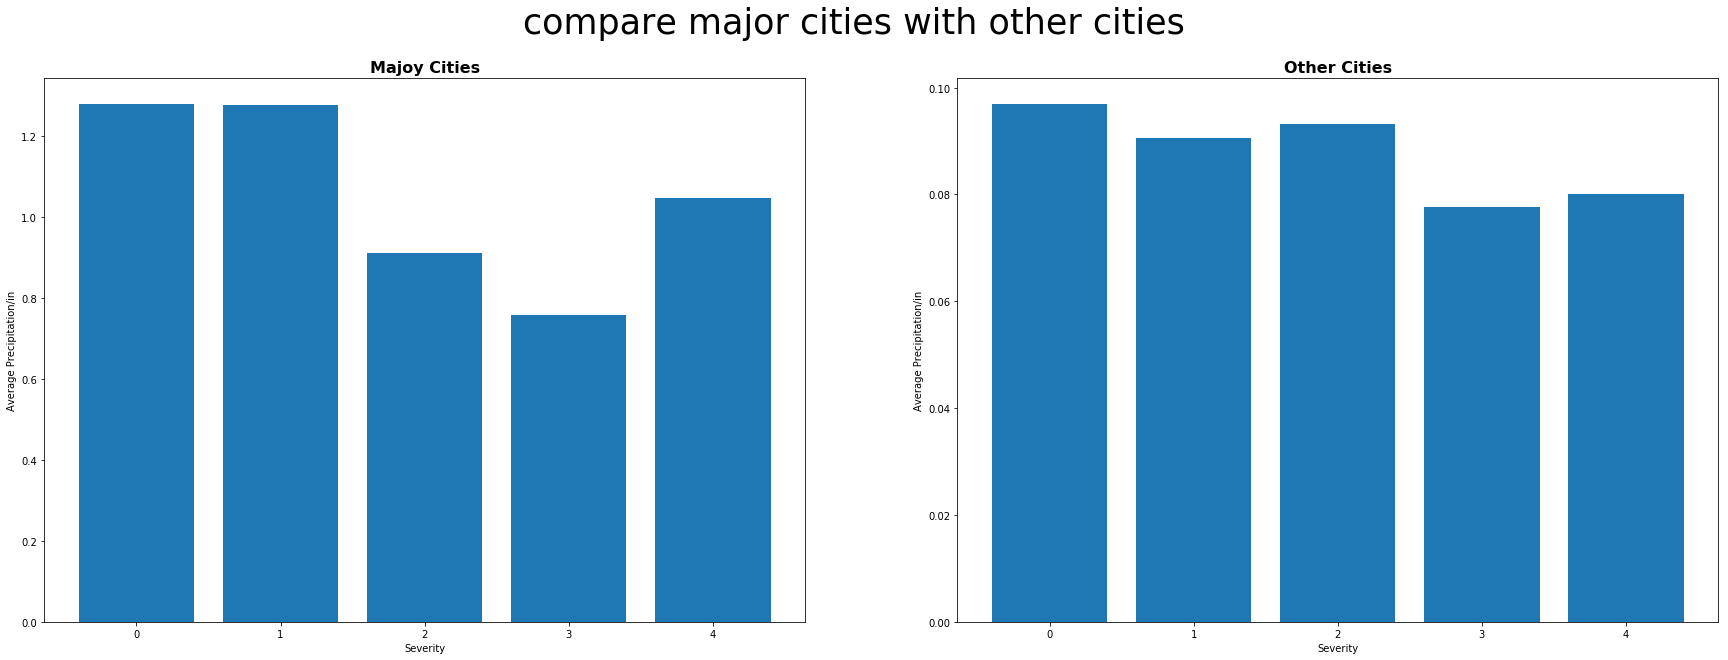

In [11]:

fg, axes = plt.subplots(1, 2, figsize=(30, 10))
plt.suptitle('compare major cities with other cities',fontsize=35)
major_cities=data.loc[data['City'].isin(cities)]
other_cities=data.loc[data['City'].isin(cities)==False]
distribution(major_cities,axes[0],'Majoy Cities')
distribution(other_cities,axes[1],'Other Cities')


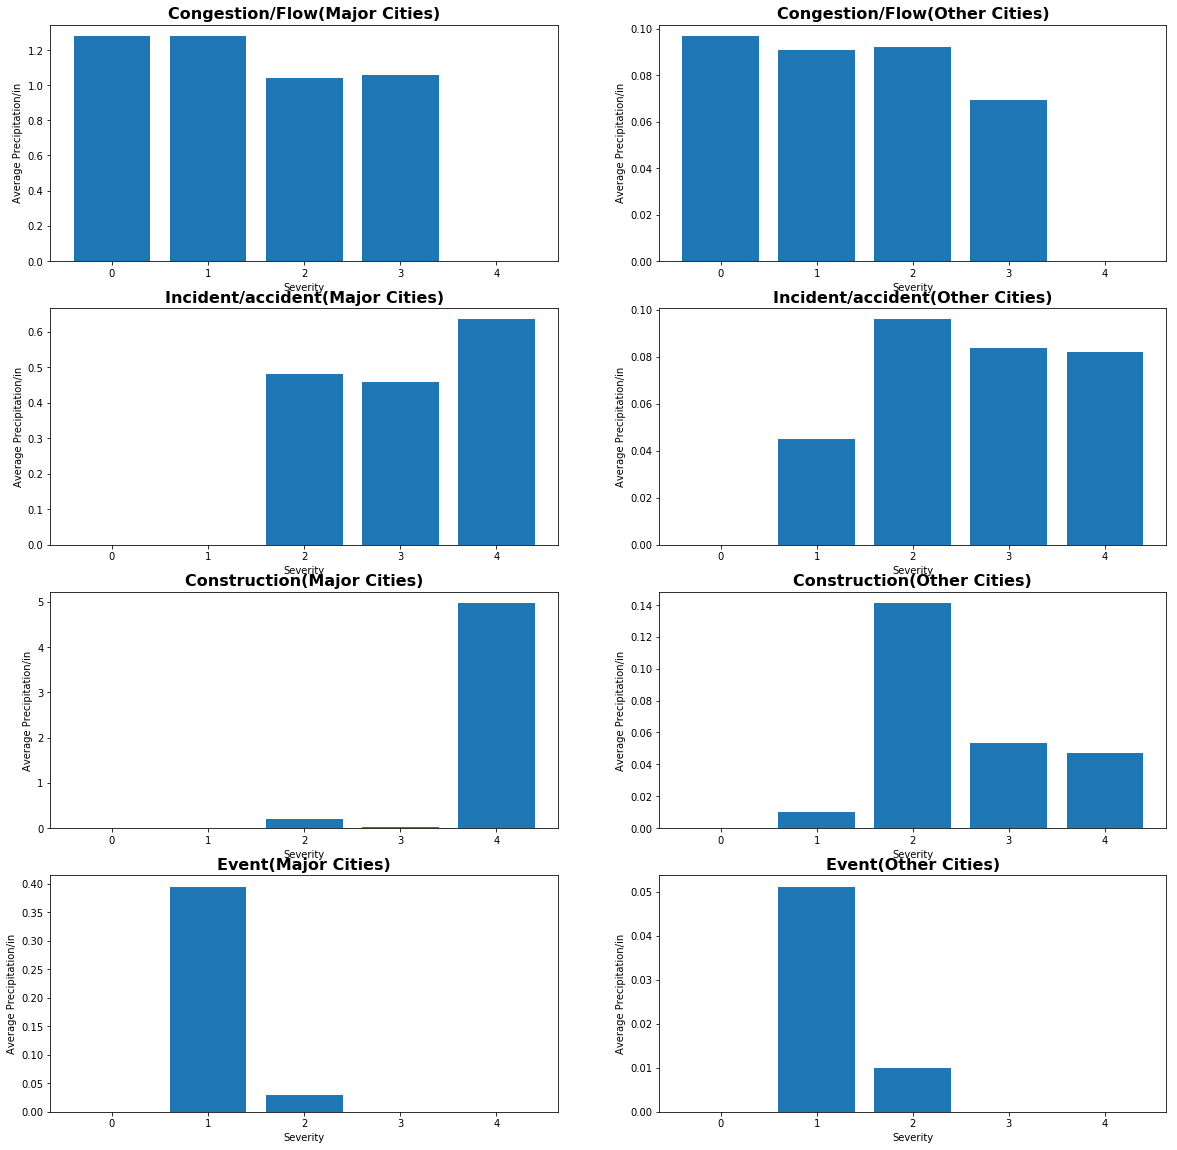

In [12]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    distribution(major_cities[major_cities['Type']==kinds[i]],axes[i][0],kinds[i]+"(Major Cities)")
for i in range(len(kinds)):
    distribution(other_cities[other_cities['Type']==kinds[i]],axes[i][1],kinds[i]+"(Other Cities)")

The major cities have quite similar pattern with other cities.

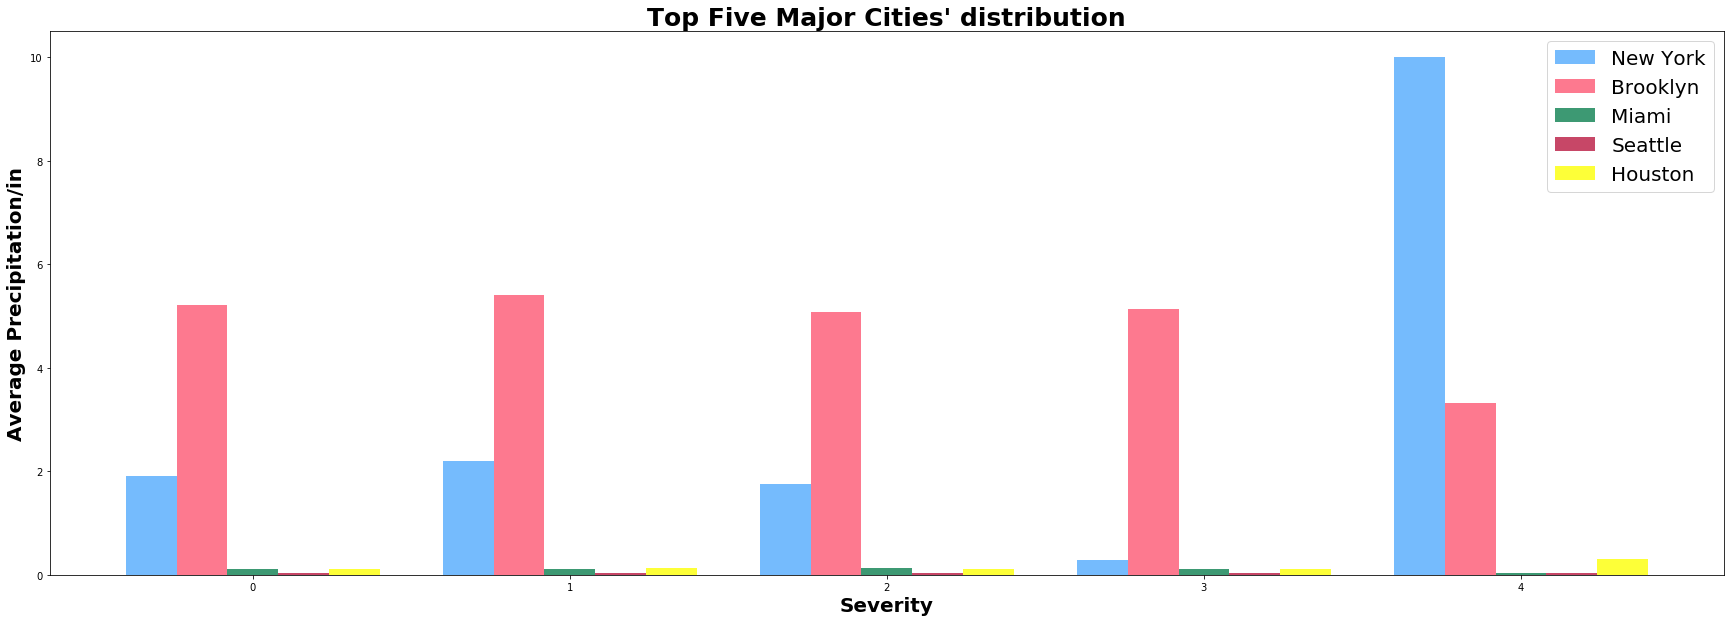

In [16]:
top_five=cities[:5]
plt.figure(figsize=(30,10))

x =list(range(5))  
total_width, n = 0.8, 5  
width = total_width / n  
cl=['lemon yellow','deep rose','ocean green','carnation','sky blue']
for city in top_five:
    target=data[data['City']==city]
    value = target.groupby('Severity')['Precipitation(in)'].mean()
    plt.bar(x, [value[i] if i in value else 0 for i in range(5)], width=width, label=city,fc ='xkcd:'+cl.pop())
    for i in range(len(x)):
        x[i]+=width
plt.xticks([i+2*width for i in range(5)],range(5))
plt.xlabel('Severity',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.ylabel('Average Precipitation/in',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.legend(prop = {'size':20})
plt.title("Top Five Major Cities\' distribution", fontdict={'fontsize': 25, 'fontweight': 'bold'})
pass

The graph shows average precipitation omf diffrent place is various.

## frequency of precipitation

### overall

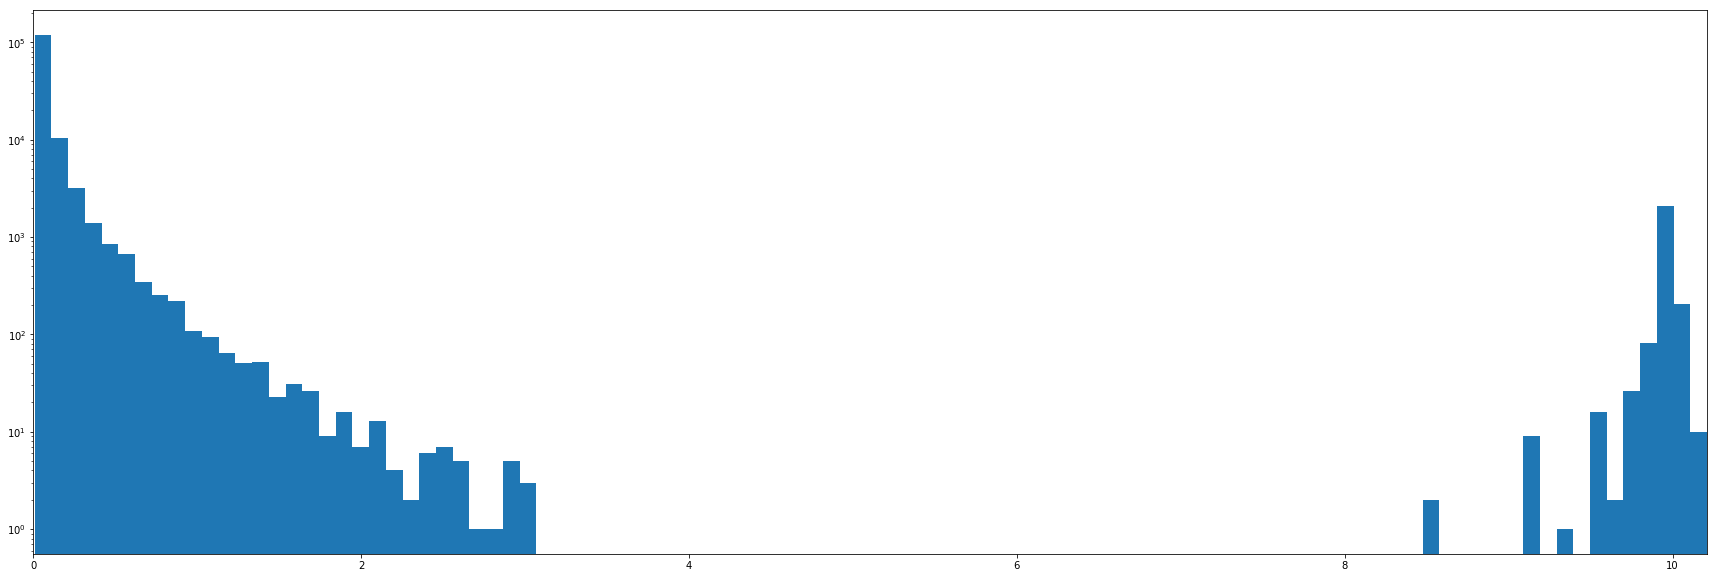

In [17]:
overall=data['Precipitation(in)']
plt.figure(figsize=(30, 10))
hhh = overall.sort_values(inplace=False)
plt.hist(hhh, bins=100)
plt.xlim(0, max(hhh))
plt.yscale('log')

In [18]:
def hist(df,ax,title):
    h=df.sort_values(inplace=False)
    ax.hist(h,bins=100,log=True)
    ax.set_title(title)

### different types

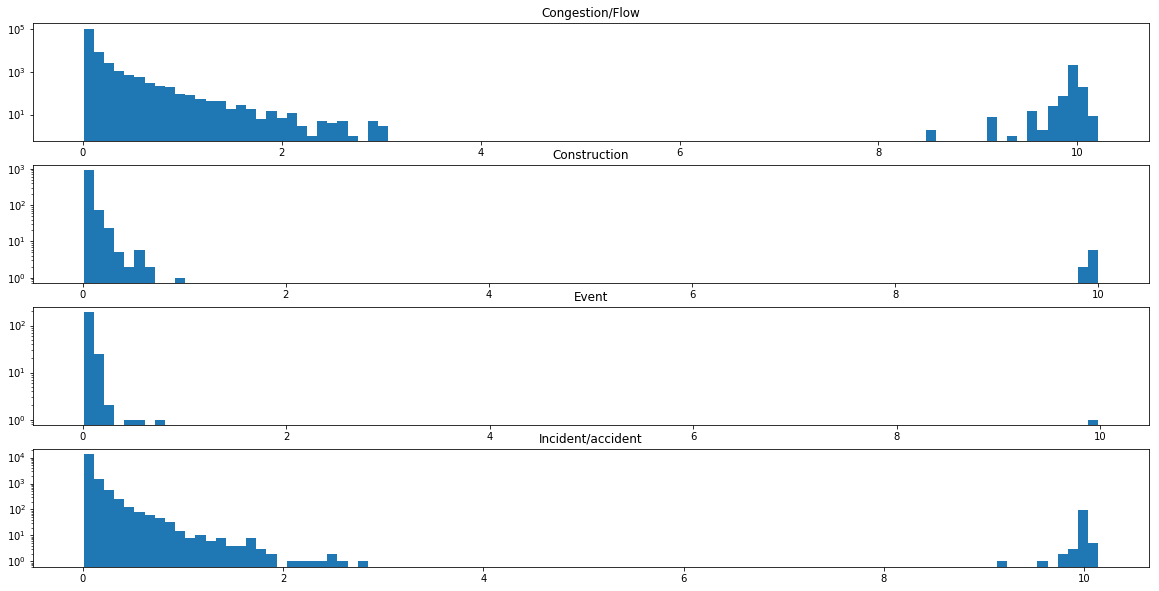

In [20]:
groupby = data.groupby('Type')['Precipitation(in)']
name,groups=zip(*groupby)
fg, axes = plt.subplots(4, 1, figsize=(20, 10))
for i in range(len(groups)):
    hist(groups[i],axes[i],name[i])

Due to the ditribution is based on a sample data, do not make further conclusion.

In [21]:
def type_distribution(part, ax, title):
    groupby = part.groupby('Type')['Type'].count()
    labels= groupby.keys()
    values = groupby.values
    ax.axis('equal')
    ax.pie(values, labels=labels)
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})

In [22]:
def severity_distribution(part, ax, title):
    groupby = part.groupby('Severity')['Severity'].count()
    labels= groupby.keys()
    values = groupby.values
    ax.axis('equal')
    ax.pie(values, labels=labels)
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})

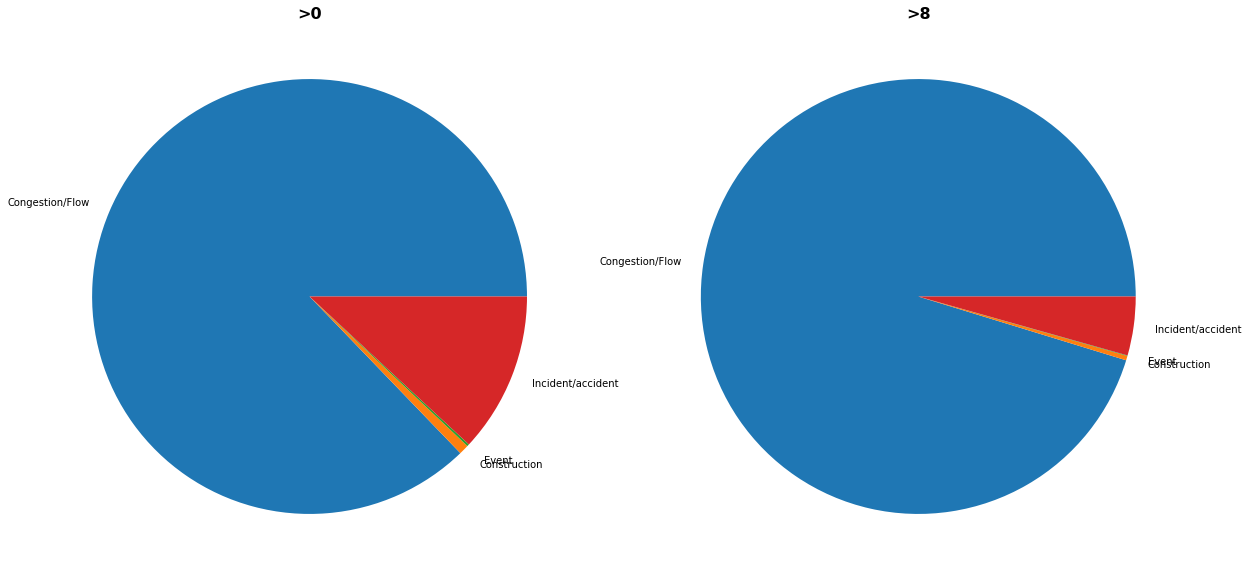

In [38]:
cmp=data[data['Precipitation(in)']>8]
fg, axes = plt.subplots(1, 2, figsize=(20, 10))
type_distribution(data,axes[0],'>0')
type_distribution(cmp,axes[1],'>8')

## the correlation between severity of traffic incident and weather precipitation

### ordinal to ordinal

In this part of analysis, we consider whether severity and severity of events as ordinal data. 

In [27]:
records['WeatherSeverity'].unique()

array([nan, 'light', 'moderate', 'heavy'], dtype=object)

In [30]:
records['Severity'].unique()

array([1, 2, 3, 4, 0], dtype=int64)

We should only use records with Weather Severity. And nomalize both severities.

In [32]:
records=records[records['WeatherSeverity'].notnull()]

In [63]:
def correlation(df):
    temp=df['WeatherSeverity'].copy()
    dic={'light':0,'moderate':0.5,'heavy':1}
    temp=temp.map(lambda x:dic[x])
    temp=pd.concat([temp,records['Severity']/4],axis=1)
    return pd.Series([temp.corr().iloc[0,1],temp.corr('kendall').iloc[0,1],temp.corr('spearman').iloc[0,1]],index=["pearson","kendall","spearman"])

overall:

In [64]:
correlation(records)

pearson    -0.012271
kendall    -0.012965
spearman   -0.014095
dtype: float64

major cities and other cities(redefined):

In [65]:
major=records.loc[records['City'].isin(cities)]
other=records.loc[records['City'].isin(cities)==False]
correlation(major)

pearson    -0.048267
kendall    -0.047802
spearman   -0.052560
dtype: float64

In [66]:
correlation(other)

pearson    -0.005364
kendall    -0.004932
spearman   -0.005345
dtype: float64

Major cities' correlation is more apparent.

In [74]:
mylist=[]
for i in range(len(kinds)):
    mylist.append(correlation(records[records['Type']==kinds[i]]))
temp=pd.concat(mylist,axis=1)
temp.rename(columns={i:kinds[i] for i in range(len(kinds))})

,Congestion/Flow,Incident/accident,Construction,Event
pearson,0.004292,0.026443,0.052588,-0.043625
kendall,0.000207,0.028412,0.052744,-0.045122
spearman,0.000226,0.029024,0.053529,-0.045388


This shows that incident and construction have more apprent positive correlation.

In [77]:
mylist=[]
for i in range(len(kinds)):
    mylist.append(correlation(major[major['Type']==kinds[i]]))
temp=pd.concat(mylist,axis=1)
temp.rename(columns={i:kinds[i] for i in range(len(kinds))})

,Congestion/Flow,Incident/accident,Construction,Event
pearson,-0.030271,0.026372,0.030221,-0.080064
kendall,-0.029279,0.007354,0.005208,-0.080064
spearman,-0.031939,0.007522,0.005155,-0.080064


In [78]:
mylist=[]
for i in range(len(kinds)):
    mylist.append(correlation(other[other['Type']==kinds[i]]))
temp=pd.concat(mylist,axis=1)
temp.rename(columns={i:kinds[i] for i in range(len(kinds))})

,Congestion/Flow,Incident/accident,Construction,Event
pearson,0.011625,0.026380,0.051520,-0.039157
kendall,0.008259,0.030969,0.053083,-0.040618
spearman,0.008854,0.031649,0.053883,-0.040880


### nominal to nominal

We could also regard severity of events as nominal value, and directly calculate the possibility that they have correlation by chi-squared test.  

We could use function:chi2_contingency to directly get the p_value and dof. The meaning of p_value is the possibility that the two values are mutual independent. Thus, the smaller p-value is, the stronger correlation exists.

In [81]:
def calculate_p(temp):
    from scipy.stats import chi2_contingency
    data=np.array(pd.crosstab(temp['Severity'],temp['WeatherSeverity'],margins=False))
    value,p,dof,ex=chi2_contingency(data)
    return p

In [82]:
mylist=[]
for i in range(len(kinds)):
    mylist.append(calculate_p(records[records['Type']==kinds[i]]))
for i in range(len(mylist)):
    mylist[i]=round(mylist[i],5)
pd.Series(mylist,index=kinds)

Congestion/Flow      0.00000
Incident/accident    0.00029
Construction         0.31722
Event                0.72998
dtype: float64

It clearly shows that the congestion and incident have a stronger correlation with weather's severity.   
While on the other hand, construction have correlation but not reliable.(has 32% possiblity that it has no correlation with weather severity) And Event could be considered as no apprent correlation with weather severity.